## Pytorch code percolation model with Ohtsuki CNN

## initializations

In [1]:
%reload_ext autoreload
%autoreload 2?
%matplotlib inline

In [2]:
seed=42
import torch
torch.manual_seed(seed)
import numpy as np
np.random.seed(seed+1)

In [3]:
from __future__ import print_function, division
import os
print('torch version:',torch.__version__)
import sklearn
print('sklearn version:', sklearn.__version__)

torch version: 1.3.1
sklearn version: 0.22.1


In [4]:
import torchvision
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
import time
import os
import copy

In [5]:
t=torch.Tensor()
print(t.dtype)
print(t.device)
print(t.layout)

torch.float32
cpu
torch.strided


Now we switch to the GPU

In [6]:
device=t.device

In [7]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
print(device)


cuda:0


## starting the main code

In [8]:
img_sizeX= 100
img_sizeY= 100 #img_sizeX
validation_split= 0.1
training_set=0
validation_set=0
dataname='L200'
path='../'+dataname

In [9]:
class DatasetFolder2(torchvision.datasets.DatasetFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(DatasetFolder2, self).__getitem__(index)
        # the image file path
        path = self.samples[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [10]:
def pickle_loader(input):
    import pickle
    return pickle.load(open(input, 'rb'))

whole_dataset= DatasetFolder2(root=path, loader=pickle_loader, extensions='.pkl')



In [11]:
data_size = len(whole_dataset)

split=int(np.floor(validation_split*data_size))
training=int(data_size-split)
# split the data into training and validation
training_set, validation_set= torch.utils.data.random_split(whole_dataset,(training,split))


In [12]:
batch_size=16
train = torch.utils.data.DataLoader(
        dataset=training_set,
        batch_size=batch_size,
        shuffle=True)

val = torch.utils.data.DataLoader(
        dataset=validation_set,
        batch_size=batch_size,
        shuffle=True)

In [13]:
class_names =whole_dataset.classes
class_names

['p0.1',
 'p0.2',
 'p0.3',
 'p0.4',
 'p0.5',
 'p0.55',
 'p0.56',
 'p0.57',
 'p0.58',
 'p0.59',
 'p0.5927',
 'p0.6',
 'p0.61',
 'p0.62',
 'p0.63',
 'p0.64',
 'p0.65',
 'p0.7',
 'p0.8',
 'p0.9']

In [14]:
def imshow(inp, title=None):
    # torch convention gives [channel, height,width] but imshow gives [height,width,channel] hence the transpose
    inp = inp.numpy().transpose((1, 2, 0))
    plt.figure()
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # Pause a bit so that plots are updated



In [15]:
inputs, labels, paths=next(iter(train))

In [16]:
img_sizeX,img_sizeY= inputs.shape[-1],inputs.shape[-2]
img_sizeY

200

In [17]:
batch_size=16
num_of_train_samples = len(training_set) # total training samples
num_of_test_samples = len(validation_set) #total validation samples
steps_per_epoch = np.ceil(num_of_train_samples // batch_size)
number_classes = len(class_names)
print(num_of_train_samples)
print(num_of_test_samples )
print(len(train)) 
print(len(val))
print(number_classes )

18000
2000
1125
125
20


## building the CNN

In [18]:
class Network(nn.Module):   
    def __init__(self):
        super(Network, self).__init__()
        # Defining a 2D convolution layer
        self.conv1=nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=0, bias=False)
        self.conv2=nn.Conv2d(in_channels=16, out_channels=16, kernel_size=5, stride=1, padding=1, bias=False)
       
            
        # Defining another 2D convolution layer
        self.conv3=nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=0, bias=False)
        self.conv4=nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1, bias=False)
            
            
        self.conv5=nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0, bias=False)
        self.conv6=nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False)
                  
        self.fc1=nn.Linear(in_features=30976, out_features=64,bias=False) 
        self.fc2=nn.Linear(in_features=64,out_features=number_classes,bias=False)
        

    # Defining the forward pass    
    def forward(self, x):
        x = self.conv1(x)
        x=F.relu(x)
        x = self.conv2(x)
        x=F.relu(x)
        x=F.max_pool2d(x,kernel_size=2, stride=2)
        x=F.dropout(x,p=0.5)
        
        
        
        x = self.conv3(x)
        x=F.relu(x)
        x = self.conv4(x)
        x=F.relu(x)
        x=F.max_pool2d(x,kernel_size=2, stride=2)
        x=F.dropout(x,p=0.5)
        
        
        
        x = self.conv5(x)
        x=F.relu(x)
        x = self.conv6(x)
        x=F.relu(x)
        x=F.max_pool2d(x,kernel_size=2, stride=2)
        x=F.dropout(x,p=0.5)
        
        #Beginning of dense layers
        x = x.view(x.size(0), -1) #flatten the network
        x=self.fc1(x)
        x=self.fc2(x)    
        
    
        return x

In [19]:
model=Network()
# defining the optimizer

optimizer=torch.optim.Adadelta(model.parameters(), lr=1.0, rho=0.9, eps=1e-06, weight_decay=0)
# defining the loss function
criterion = nn.CrossEntropyLoss()

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    
#print(model)


In [20]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Model's state_dict:
conv1.weight 	 torch.Size([16, 1, 5, 5])
conv2.weight 	 torch.Size([16, 16, 5, 5])
conv3.weight 	 torch.Size([32, 16, 3, 3])
conv4.weight 	 torch.Size([32, 32, 3, 3])
conv5.weight 	 torch.Size([64, 32, 3, 3])
conv6.weight 	 torch.Size([64, 64, 3, 3])
fc1.weight 	 torch.Size([64, 30976])
fc2.weight 	 torch.Size([20, 64])
Optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 1.0, 'rho': 0.9, 'eps': 1e-06, 'weight_decay': 0, 'initial_lr': 1.0, 'params': [140427271610112, 140427271609392, 140427271610192, 140427271609552, 140427271609872, 140427271609472, 140429349928144, 140427136583392]}]


In [21]:
# for param in model.parameters():
#     print(param.shape)

In [22]:
#the model is sent to the GPU
model = model.to(device)


In [23]:
def train_model(model,criterion, optimizer, num_epochs, scheduler, batch_size):
    since=time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    

    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch,num_epochs-1))
        print('-' * 10)
        
    #two phases training and validating
        for phase in [train,val]:
            if phase == train:
                model.train()# set the model to training mode
            else:
                model.eval() 
                
            running_loss=0.0
            running_corrects=0.0
            
            # Here's where the training happens
            print('Iterating through data...')
            
            for i, (inputs,labels,paths) in enumerate(phase):
                inputs=inputs.unsqueeze(1)
                inputs=inputs.float() 
                inputs=inputs.to(device)
                labels=labels.to(device)
                #paths=paths.to(device)
                
                
                #put the gradient to zero to avoid accumulation during back propagation
                optimizer.zero_grad()
                
                
                #now we need to carry out the forward and backward process in different steps
                #First the forward training
                #for the training step we need to log the loss
                with torch.set_grad_enabled(phase==train):
                    outputs=model(inputs)
                    _, preds= torch.max(outputs,1)
                    loss=criterion(outputs,labels)
                
                #still for the training phase we need to implement backword process and optimization
                
                    if phase==train:
                        loss.backward()
                        optimizer.step()
                        
                # We want variables to hold the loss statistics
                #loss.item() extract the loss value as float then it is multiply by the batch size
                running_loss+=loss.item()*inputs.size(0)
                running_corrects+= torch.sum(preds==labels.data)
                
            if phase == train:
                scheduler.step()

                
            
            if phase ==train:
                epoch_loss= running_loss/len(phase.dataset)
                epoch_acc = running_corrects.double()/ len(phase.dataset)
                print('{} loss: {:4f} accuracy: {:4f}'.format(
                'training', epoch_loss, epoch_acc
            ))
                
            
            if phase==val:
                epoch_loss= running_loss/len(val.dataset)
                epoch_acc = running_corrects.double()/len(val.dataset)
                print('{} val_loss: {:4f} val_accuracy: {:4f}'.format(
            'validation:', epoch_loss, epoch_acc
            ))
            # Make a copy of the model if the accuracy on the validation set has improved
            if phase == val and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Now we'll load in the best model weights and return it
    model.load_state_dict(best_model_wts)
    return model

                    
        

In [24]:
num_epochs=10
base_model = train_model(model, criterion, optimizer,num_epochs,exp_lr_scheduler,batch_size=16 )


Epoch 0/9
----------
Iterating through data...
training loss: 3.187028 accuracy: 0.217278
Iterating through data...
validation: val_loss: 1.836620 val_accuracy: 0.407500

Epoch 1/9
----------
Iterating through data...
training loss: 1.685281 accuracy: 0.397111
Iterating through data...
validation: val_loss: 1.219976 val_accuracy: 0.527500

Epoch 2/9
----------
Iterating through data...
training loss: 1.506111 accuracy: 0.458111
Iterating through data...
validation: val_loss: 1.284731 val_accuracy: 0.489000

Epoch 3/9
----------
Iterating through data...
training loss: 1.503464 accuracy: 0.456833
Iterating through data...
validation: val_loss: 1.538217 val_accuracy: 0.445500

Epoch 4/9
----------
Iterating through data...
training loss: 1.445971 accuracy: 0.469278
Iterating through data...
validation: val_loss: 1.472427 val_accuracy: 0.418500

Epoch 5/9
----------
Iterating through data...
training loss: 1.734347 accuracy: 0.407833
Iterating through data...
validation: val_loss: 1.45919

In [25]:
#save the model
PATH = './perco_density_'+dataname+'_OhtsukiCNN_matrix_L200'+'.pth'
torch.save(model.state_dict(), PATH)

In [26]:
#visualize_model_misclassified(model, num_images=30)

## testing the quality of the learned model

In [27]:
@torch.no_grad()
def simple_confusion_matrix(model,loader):
    confusion_matrix = torch.zeros(number_classes, number_classes)
    for i, (inputs,labels,outputs) in enumerate(loader):
        inputs=inputs.unsqueeze(1) 
        inputs=inputs.float() 
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1) 
        for t, p in zip(labels.view(-1), preds.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1
                

    return confusion_matrix

In [28]:
cm=simple_confusion_matrix(model,val)
cm

tensor([[112.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  4., 110.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0., 100.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   2.,  91.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0., 111.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   3.,  55.,  30.,   9.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,  17.,  40.,  43.,   6.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0., 

In [29]:
def confusion_matrix_torch(cm, target_names,cmap=None,title='Confusion Matrix'):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    #accuracy = np.trace(cm) / float(np.sum(cm))
    #misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(25, 25))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,fontsize=40)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45, fontsize=30)
        plt.yticks(tick_marks, target_names,fontsize=30)

            
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j]),
                    ha="center", va="center",
                    color="white" if  cm[i, j] == 0 or cm[i, j] > thresh else "black") 


    plt.tight_layout()
    plt.ylabel('True label',fontsize=40)
    plt.xlabel('Predicted label',fontsize=40)
    plt.show()

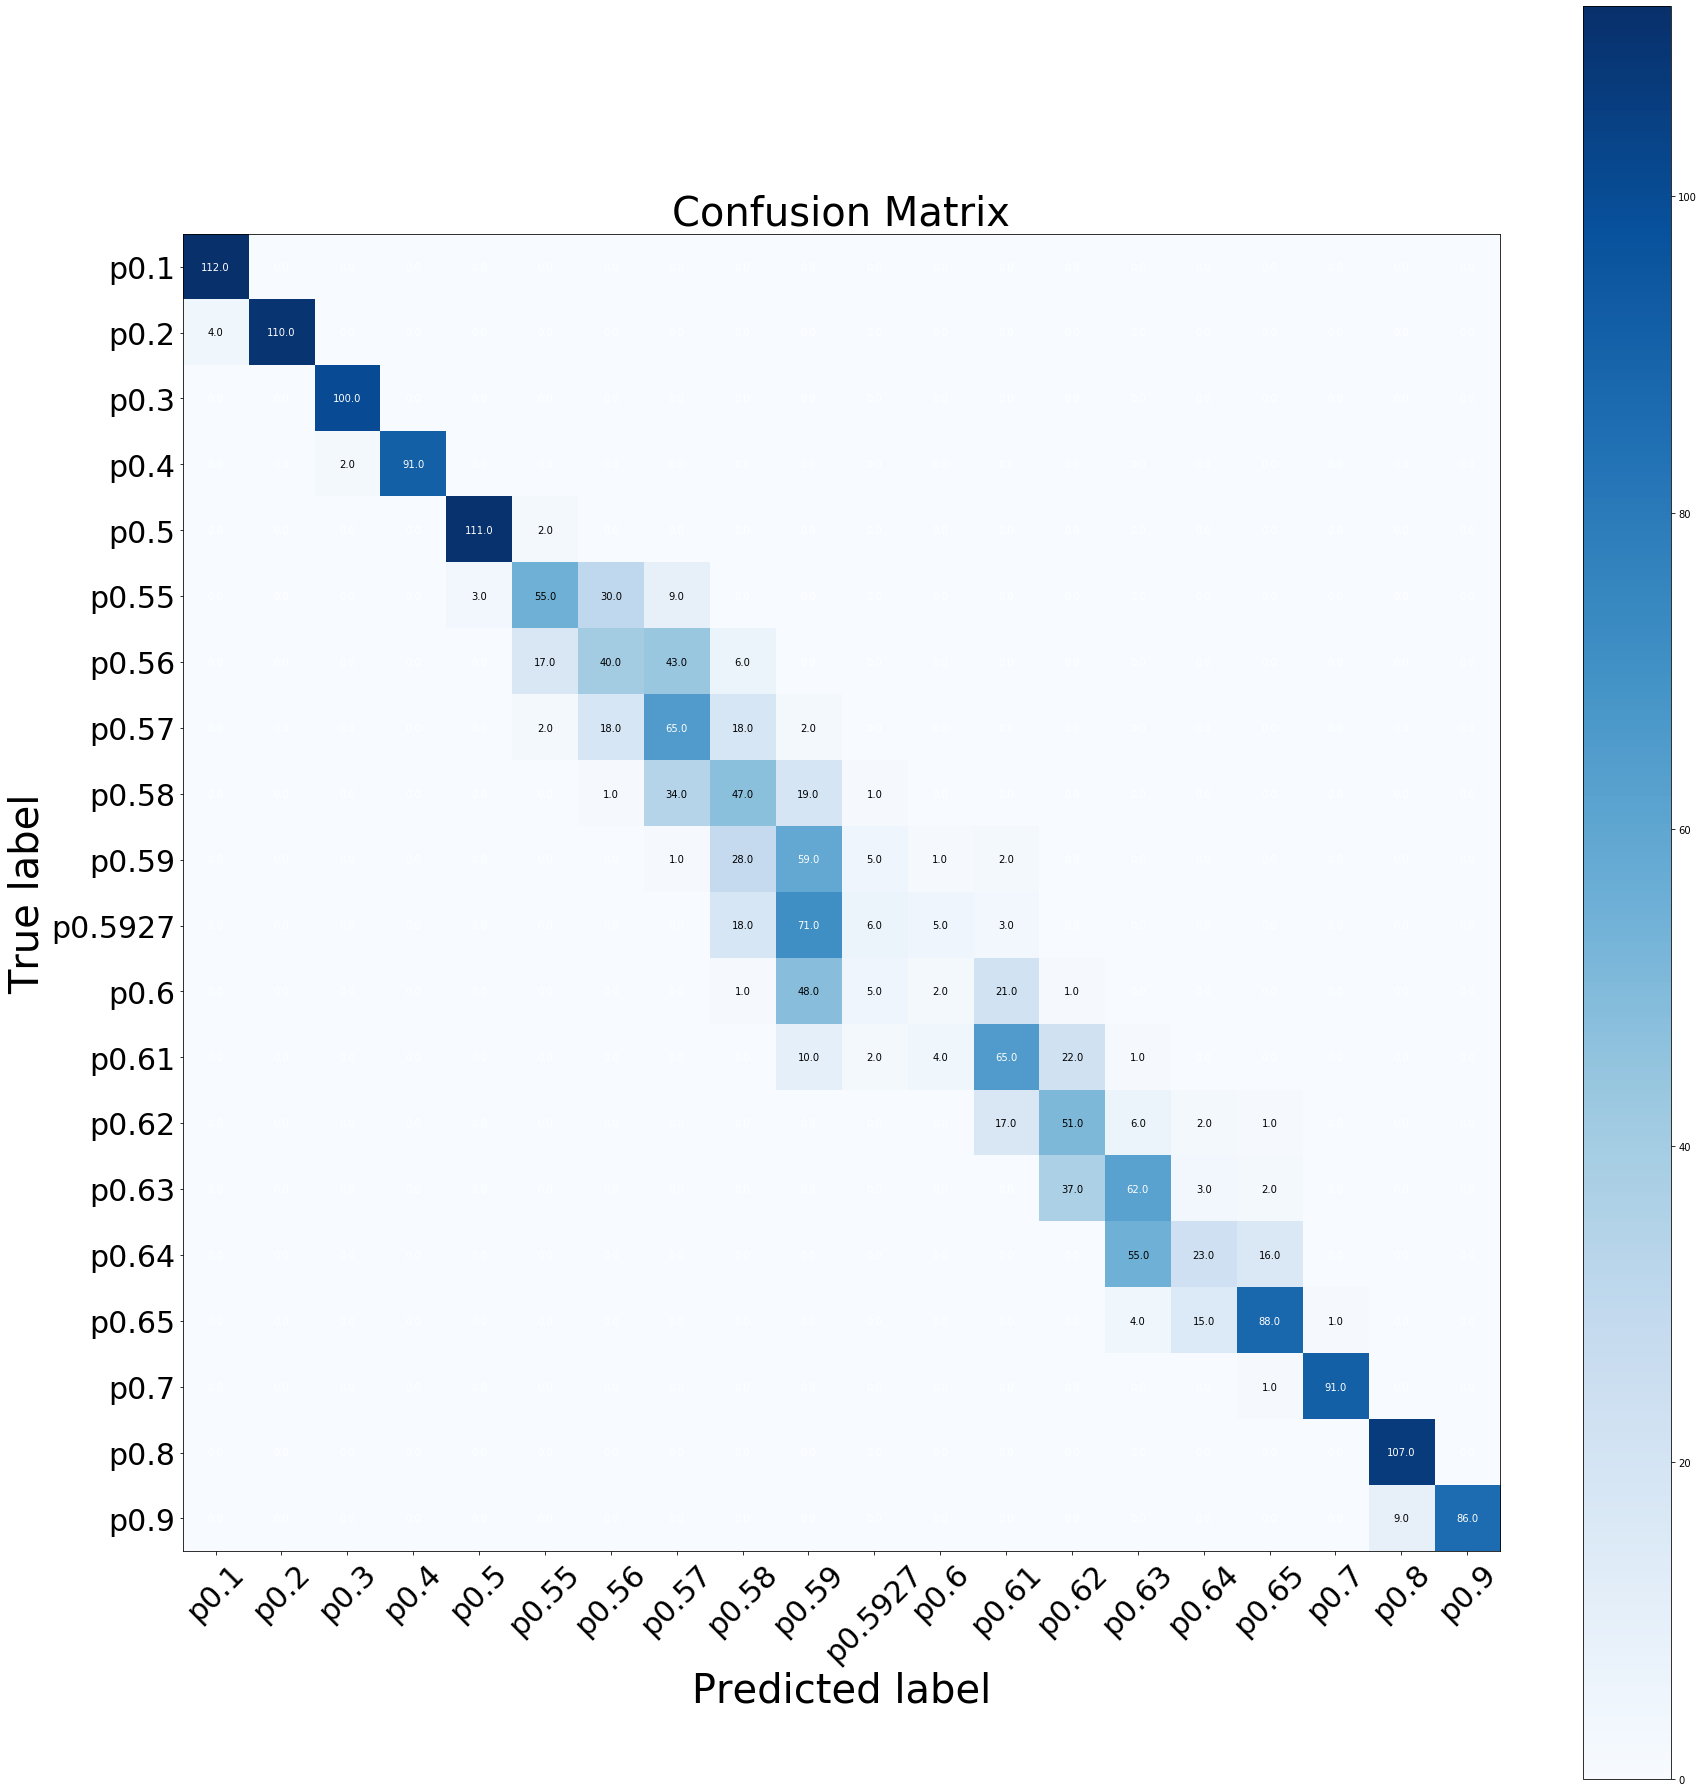

In [30]:
confusion_matrix_torch(cm,class_names)